## Harth Majeed - Assignment 4

In [8]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13120394767342227812
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7802454016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15281984482080170202
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Num GPUs Available:  1


### Imports

In [15]:
from __future__ import print_function

#import Agent and Environment
from Agent import Agent
from Environment import Environment

import numpy as np
from IPython.display import clear_output
import random
from random import randint
from matplotlib import pylab as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow.keras.backend as K
from tensorflow.keras import activations
from keras.utils import np_utils

import pickle
tf.__version__

'2.7.0'

### Testing to ensure the code works

In [16]:
agent = Agent()
env = Environment(4, 4, 0.2, agent)

In [17]:
env.action(1)
env.visualize()


[ b ][ PG ][ bs ][  ]
[  ][ bs ][ W ][ s ]
[  ][  ][ s ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[2, 2]]
wumpusAlive:  True
Gold Location:  [[3, 1]]
Pit Locations:  [[3, 1]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  1

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 1 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-----------

In [22]:
action_set = {
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5,
    5: 6
}
#1: 'forward',
#2: 'turnLeft',
#3: 'turnRight',
#4: 'grab',
#5: 'shoot',
#6: 'climb'

### Creating the Model

In [19]:
input_d = 72
output_d = 6
learning_rate = 0.0001 #5*10**(-4)

def create_model():
    inputs = Input(shape=(input_d,))
    layer1 = Dense(512,activation='relu')(inputs)
    layer2 = Dense(128,activation='relu')(layer1)
    layer3 = Dense(128,activation='relu')(layer2)
    layer4 = Dense(128,activation='relu')(layer3)
    action = Dense(output_d,activation='linear')(layer4)
    return keras.Model(inputs=inputs, outputs=action)

In [20]:
model = create_model() 
model2 = create_model() 
model.summary()
model2.summary()

model2.set_weights(model.get_weights())
optimizer = Adam(learning_rate = learning_rate)
loss_function = MeanSquaredError()

model.compile(optimizer = optimizer, loss=loss_function)
model2.compile(optimizer = optimizer, loss=loss_function)
model2.set_weights(model.get_weights()) 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 72)]              0         
                                                                 
 dense_10 (Dense)            (None, 512)               37376     
                                                                 
 dense_11 (Dense)            (None, 128)               65664     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 6)                 774       
                                                                 
Total params: 136,838
Trainable params: 136,838
Non-trainable

### Training the Model

In [45]:
import timeit
from collections import deque
from IPython.display import display, clear_output
from datetime import datetime
starttime = datetime.now()

epochs = 4000
mem_size = 10000000
batch_size = 128
replay = deque(maxlen=mem_size)
max_moves = 250 #1250
sync_freq = 500 #1500 
gamma = 0.85

epsilon_min = 0.03  # Minimum epsilon greedy parameter
epsilon0 = 0.9


win_num = 0
win_num_list = []
actions_list = []
losses = []
h = 0
j=0
for i in range(epochs):
    agent = Agent()
    game = Environment(4, 4, 0.2, agent)
    losses_episode = []
    state1_ = game.generateInputs().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state1 = tf.convert_to_tensor(state1_, dtype=float, dtype_hint=None, name=None)
    status = 1
    mov = 0
    epsilon0 = epsilon0*0.999
    epsilon = max(epsilon0, epsilon_min)
    while(status == 1): 
        j += 1
        mov += 1
        qval_ = model(state1, training=False) 
        if (random.random() < epsilon): 
            action_ = np.random.randint(0,6)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        #print(action_)
        #print(type(action_))
        #print(action)
        #print(type(action))
        #print(qval_)
        #print(type(qval_))
        #print()
        game.action(action)
        state2_ = game.generateInputs().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state2 = tf.convert_to_tensor(state2_, dtype=float, dtype_hint=None, name=None)
        reward = game.agent.score
        done = 1. if (game.gameTerminated) else 0.
        exp =  (state1, action_, reward, state2, done) 
        replay.append(exp) 
        state1 = state2
        
        if len(replay) > batch_size: 
            minibatch = random.sample(replay, batch_size) 
            state1_batch = tf.concat([s1 for (s1,a,r,s2,d) in minibatch],0) 
            action_batch = tf.constant([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = tf.constant([r for (s1,a,r,s2,d) in minibatch],dtype=float)
            state2_batch = tf.concat([s2 for (s1,a,r,s2,d) in minibatch],0)
            done_batch = tf.constant([d for (s1,a,r,s2,d) in minibatch])
            
            Q2 = model2(state2_batch,training=False) 
            Y = reward_batch + gamma * ((tf.constant(1.) - done_batch) * tf.math.reduce_max(Q2,axis=1)) #N
            masks = tf.one_hot(action_batch, 6)
                        
            with tf.GradientTape() as tape:
                Q1 = model(state1_batch) 
                Y_action = tf.reduce_sum(tf.multiply(Q1, masks), axis=1)
                loss = loss_function(Y, Y_action)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss.numpy())
            losses_episode.append(loss.numpy())
            
            if j % sync_freq == 0: 
                model2.set_weights(model.get_weights())
#                 print('!!!!!!!!!!!!sync happened!!!!!!!!!!!!')
                
        if game.gameTerminated or mov > max_moves: #O
            status = 0
            mov = 0
            if len(losses_episode)!=0:
                print("Episode num: {}, average loss: {}".format(i, sum(losses_episode)/len(losses_episode)))
            if game.agent.score>0:
                print("Game won! Current reward: {}, Agent has gold: {}".format(game.agent.score, game.agent.hasGold))
                win_num += 1
            else:
                print("Game lost! Current reward: {}, Agent has gold: {}".format(game.agent.score,game.agent.hasGold))
                if game.agent.score == -1:
                    print("Last action:", action)
            if i%10 == 9:
                print("Attention! Win # in last 10 episodes:", win_num)
                win_num_list.append(win_num)
                win_num = 0
            if i%50 == 49:
                clear_output(wait=True)
                

losses = np.array(losses)
print("start time: ", starttime.strftime("%H:%M:%S"))
print("end time: ", datetime.now().strftime("%H:%M:%S"))

start time:  18:23:50
end time:  21:53:18


### Plotting the Figures

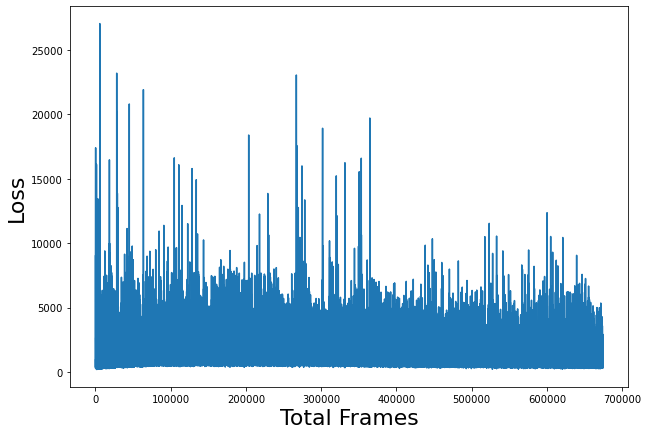

In [46]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Total Frames",fontsize=22)
plt.ylabel("Loss",fontsize=22)
plt.show()

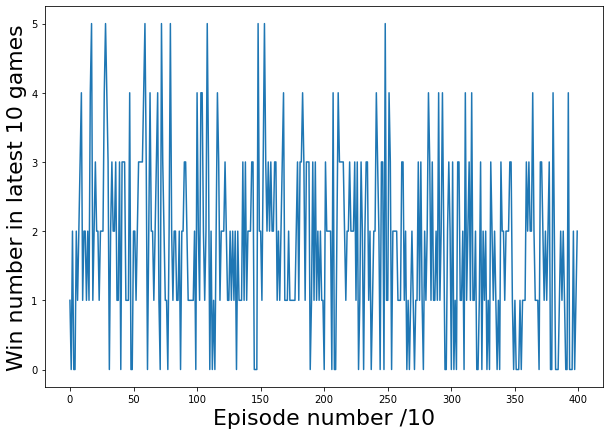

In [47]:
plt.figure(figsize=(10,7))
plt.plot(win_num_list)
plt.xlabel("Episode number /10",fontsize=22)
plt.ylabel("Win number in latest 10 games",fontsize=22)
plt.show()

### Save and Load the weights

In [48]:
model.save_weights('model_dense_72_512_128_128_128.h5')

In [49]:
model.load_weights('model_dense_72_512_128_128_128.h5')

### Testing the Model

In [63]:
def test_keras_model(model, max_moves,display=True):
    clear_output(wait=True)
    i = 0
    agent = Agent()
    test_game = Environment(4, 4, 0.2, agent)
    goldinPW = 1. if test_game.goldLocation in test_game.wumpusLocation or (test_game.goldLocation in test_game.pitLocations) else 0.
    stuck = 0
    die = 0
    winnogold = 0

    
    state_ = test_game.generateInputs().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
    state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
    if display:
        print("Initial State:")
        print(test_game.visualize())
    status = 1
    while(status == 1):
        qval_ = model(state,training=False)
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.action(action)
        state_ = test_game.generateInputs().reshape(1,input_d) + np.random.rand(1,input_d)/100.0
        state = tf.convert_to_tensor(state_, dtype=float, dtype_hint=None, name=None)
        if display:
            print(test_game.visualize())
        reward = test_game.agent.score
        total_reward = test_game.agent.score
        if test_game.gameTerminated:
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (test_game.agent.score))
            else:
                if goldinPW and action=='Climb':
                    status = 2
                    winnogold += 1.
                    if display:
                        print("Game won! Reward: %s" % (test_game.agent.score),"choose to climb out without gold")
                else:    
                    status = 0
                    die = 1
                    if display:
                        print("Game LOST. Reward: %s" % (test_game.agent.score))
        i += 1
        if (i > max_moves):
            stuck=1
            if display:
                print("Game lost; too many moves.")
            break
   
    win = True if status == 2 else False
    pitnum = [0,0,0,0,0]
    win_in_pitnum = [0,0,0,0,0]
    num_of_pits = len(test_game.pitLocations)
    if num_of_pits == 0:
        pitnum[0]=1.
        if win:
            win_in_pitnum[0]=1.
    if num_of_pits == 1:
        pitnum[1]=1.
        if win:
            win_in_pitnum[1]=1.
    if num_of_pits == 2:
        pitnum[2]=1.
        if win:
            win_in_pitnum[2]=1.
    if num_of_pits == 3:
        pitnum[3]=1.
        if win:
            win_in_pitnum[3]=1.
    if num_of_pits >= 4:
        pitnum[4]=1.
        if win:
            win_in_pitnum[4]=1.
#     print("Reward:", test_game.agent.totalreward, win,action)
#     print(test_game.visualize())
    return win,total_reward,goldinPW,stuck,die,np.array(pitnum),np.array(win_in_pitnum),winnogold

#### Testing the code with a sample game

In [61]:
# sample game
test_keras_model(model,1000,display=True)

Initial State:

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[ A ][  ][  ][  ]
Agent Location:  [0, 0]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  0
Action Count (Game loop):  0

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 8; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  9

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ]

Move #: 16; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  17

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionS

[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 25; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  26

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0

Move #: 34; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  35

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionS

[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 43; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  44

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ]

Move #: 52; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  53

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionS

[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  62

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------


[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  71

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-----------

Move #: 80; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  81

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionS

Move #: 89; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  90

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionS

[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 98; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  99

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ]

Move #: 107; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  108

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directio

Move #: 117; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  118

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directio

[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 127; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  128

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0

Move #: 136; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  137

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directio

[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 146; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  147

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[

Move #: 155; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  156

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directio


[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  165

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

----------

[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 174; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  175

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[

[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 183; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count

[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 192; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Sc

Move #: 201; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  202

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directio

[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 210; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  211

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[

[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize-------------

None
Move #: 220; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  221

A

Move #: 229; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  230

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directio

Move #: 238; Taking action: 6

[  ][ b ][ Ps ][ Wbs ]
[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  239

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directio

[  ][  ][ b ][ s ]
[  ][ G ][  ][  ]
[  ][ A ][  ][  ]
Agent Location:  [0, 1]  Direction:  EAST
Agent has Gold:  False
Agent Perceives Glitter:  False
Agent hasArrow:  True
Agent Heard Scream:  False
Agent isAlive:  True
Wumpus Location:  [[3, 3]]
wumpusAlive:  True
Gold Location:  [[1, 1]]
Pit Locations:  [[3, 2]]
Pit Prob:  0.2
AllowClimbWithoutGold:  False
gameTerminated:  False
Agent Score:  -1
Action Count (Game loop):  248

Agent Location Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 1 ][ 0 ][ 0 ]

Agent Visited Array
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 1 ][ 0 ][ 0 ][ 0 ]

Stench Location Array
[ 0 ][ 0 ][ 1 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

Breeze Location Array
[ 0 ][ 1 ][ 0 ][ 1 ]
[ 0 ][ 0 ][ 1 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]
[ 0 ][ 0 ][ 0 ][ 0 ]

directionEastBool:  True
directionWestBool:  False
directionNorthBool:  False
directionSouthBool:  False

-------------Visualize------------

(False, -1, 0.0, 1, 0, array([0., 1., 0., 0., 0.]), array([0, 0, 0, 0, 0]), 0)

### Testing with 250 max moves

In [65]:
# MAX MOVES 250
max_games = 1000
wins = 0
reward = 0
goldinpwtotal = 0
stucktotal = 0
dietotal = 0
winnogoldtotal = 0
max_moves=250
pitnumtotal = np.array([0,0,0,0,0])
winpitnumtotal = np.array([0,0,0,0,0])

for i in range(max_games):
    print('currently palying game:',i+1)
    win,treward,goldinpw,stuck,die,pitnum,winpitnum,winnogold = test_keras_model(
        model, max_moves, display=False)
    reward += treward
    goldinpwtotal += goldinpw
    dietotal += die
    stucktotal += stuck
    pitnumtotal = pitnumtotal+pitnum
    winpitnumtotal = winpitnumtotal + winpitnum
    winnogoldtotal += winnogold
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
avg_reward = reward/max_games
print("Games played: {0}, number of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
print("Average reward: {}".format(avg_reward))
print("Games with gold in pits/wumpus: {0}, win rate in other games: {1}".format(goldinpwtotal,wins/(max_games-goldinpwtotal)))
print("Games stuck: {}, games died: {}".format(stucktotal,dietotal))
print("Games with pits number 0,1,2,3 and 4+: {}, win numbers in those games: {}, win ratio: {}".format(pitnumtotal,
                                                                                                        winpitnumtotal,
                                                                                                        winpitnumtotal/pitnumtotal))
#print("Climb out without gold: {}, ratio: {}".format(winnogoldtotal, winnogoldtotal/goldinpwtotal))

Games played: 1000, number of wins: 73
Win percentage: 7.3%
Average reward: 49.93
Games with gold in pits/wumpus: 0.0, win rate in other games: 0.073
Games stuck: 926, games died: 1
Games with pits number 0,1,2,3 and 4+: [118. 296. 319. 178.  89.], win numbers in those games: [23. 18. 18. 10.  4.], win ratio: [0.19491525 0.06081081 0.05642633 0.05617978 0.04494382]


### Testing with 1000 max moves

In [69]:
# MAX MOVES 1000
max_games = 1000
wins = 0
reward = 0
goldinpwtotal = 0
stucktotal = 0
dietotal = 0
winnogoldtotal = 0
max_moves=1000
pitnumtotal = np.array([0,0,0,0,0])
winpitnumtotal = np.array([0,0,0,0,0])

for i in range(max_games):
    print('currently palying game:',i+1)
    win,treward,goldinpw,stuck,die,pitnum,winpitnum,winnogold = test_keras_model(
        model, max_moves, display=False)
    reward += treward
    goldinpwtotal += goldinpw
    dietotal += die
    stucktotal += stuck
    pitnumtotal = pitnumtotal+pitnum
    winpitnumtotal = winpitnumtotal + winpitnum
    winnogoldtotal += winnogold
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
avg_reward = reward/max_games
print("Games played: {0}, number of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))
print("Average reward: {}".format(avg_reward))
print("Games with gold in pits/wumpus: {0}, win rate in other games: {1}".format(goldinpwtotal,wins/(max_games-goldinpwtotal)))
print("Games stuck: {}, games died: {}".format(stucktotal,dietotal))
print("Games with pits number 0,1,2,3 and 4+: {}, win numbers in those games: {}, win ratio: {}".format(pitnumtotal,
                                                                                                        winpitnumtotal,
                                                                                                        winpitnumtotal/pitnumtotal))
#print("Climb out without gold: {}, ratio: {}".format(winnogoldtotal, winnogoldtotal/goldinpwtotal))

Games played: 1000, number of wins: 73
Win percentage: 7.3%
Average reward: 15.149
Games with gold in pits/wumpus: 0.0, win rate in other games: 0.073
Games stuck: 927, games died: 0
Games with pits number 0,1,2,3 and 4+: [123. 278. 328. 186.  85.], win numbers in those games: [15. 25. 18. 13.  2.], win ratio: [0.12195122 0.08992806 0.05487805 0.06989247 0.02352941]


### Conclusion

In conclusion the Deep Q Network algorithm did not perform just like presented in the slides.

Several options were tried, such as:
- The learning rates: 0.0001 and 5*10**(-4)
- The number of epochs: 100, 1000, 4000
- And max moves: 250, 1000

During training the best result obtained from the tests was 7.3%, or 73 wins out of 1000 games, when using the learning rate of 0.001. When using the learning rate of '5*10**(-4)' as shown in the presentation, the results dropped to 4.4%, or 44 wins out of 1000 games. These results are poor, espically when considering that Assignment 1's randomly acting agent produced a win rate of 25%. 

In the future, if this assignment is to be used again, it might be worth looking at genetic algorithms and seeing how they compare to Deep Q Networks.